# Used Cars' Price Prediction  
Building a Linear Regression and XGBoost model to predict used car pricing.   
Trying using various forms of regularization and other nonlinear functions too for the model besides data pre-processing and featureset optimization to get optimal results.

dateCrawled : when this ad was first crawled, all field-values are taken from this date  
name : "name" of the car  
seller : private or dealer  
offerType  
price : the price on the ad to sell the car  
abtest  
vehicleType  
yearOfRegistration : at which year the car was first registered  
gearbox  
powerPS : power of the car in PS  
model  
kilometer : how many kilometers the car has driven  
monthOfRegistration : at which month the car was first registered  
fuelType  
brand  
notRepairedDamage : if the car has a damage which is not repaired yet   
dateCreated : the date for which the ad at ebay was created  
nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) )    
postalCode    
lastSeenOnline : when the crawler saw this ad last online  


In [53]:
import pandas as pd
import numpy as np

In [54]:
df_orig = pd.read_csv('userCarsDataset.csv',encoding='cp1252')
df = df_orig.copy()
df.head()

c:\users\aviral agarwal\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,1,2,3,5,6,8,10,11,13,14,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,24-03-16 11:52,Golf_3_1.6,privat,Angebot,480.0,test,NaN,1993.0,manuell,0.0,golf,150000,0.0,benzin,volkswagen,NaN,24-03-16 0:00,0.0,70435.0,07-04-16 3:16
1,24-03-16 10:58,A5_Sportback_2.7_Tdi,privat,Angebot,18300.0,test,coupe,2011.0,manuell,190.0,NaN,125000,5.0,diesel,audi,ja,24-03-16 0:00,0.0,66954.0,07-04-16 1:46
2,14-03-16 12:52,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800.0,test,suv,2004.0,automatik,163.0,grand,125000,8.0,diesel,jeep,NaN,14-03-16 0:00,0.0,90480.0,05-04-16 12:47
3,17-03-16 16:54,GOLF_4_1_4__3TÜRER,privat,Angebot,1500.0,test,kleinwagen,2001.0,manuell,75.0,golf,150000,6.0,benzin,volkswagen,nein,17-03-16 0:00,0.0,91074.0,17-03-16 17:40
4,31-03-16 17:25,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600.0,test,kleinwagen,2008.0,manuell,69.0,fabia,90000,7.0,diesel,skoda,nein,31-03-16 0:00,0.0,60437.0,06-04-16 10:17


## 1. Investigating the Dataset

#### checking for null values

In [55]:
df.isnull().sum()

dateCrawled            103701
name                   103701
seller                 103702
offerType              103702
price                  103702
abtest                 103702
vehicleType            131029
yearOfRegistration     103703
gearbox                118231
powerPS                103702
model                  118576
kilometer              103702
monthOfRegistration    103703
fuelType               127799
brand                  103703
notRepairedDamage      155716
dateCreated            103703
nrOfPictures           103703
postalCode             103703
lastSeen               103703
dtype: int64

In [56]:
df.shape

(371539, 20)

In [57]:
df1 = df.copy()

#### checking for duplicates

In [58]:
df2 = df1.drop_duplicates()
df2.shape

(267802, 20)

#### checking for null values after removing duplicate records

In [59]:
df2.isnull().sum()

dateCrawled                1
name                       1
seller                     2
offerType                  2
price                      2
abtest                     2
vehicleType            27328
yearOfRegistration         3
gearbox                14531
powerPS                    2
model                  14875
kilometer                  2
monthOfRegistration        3
fuelType               24097
brand                      3
notRepairedDamage      52011
dateCreated                3
nrOfPictures               3
postalCode                 3
lastSeen                   3
dtype: int64

In [60]:
df2.dtypes

dateCrawled             object
name                    object
seller                  object
offerType               object
price                  float64
abtest                  object
vehicleType             object
yearOfRegistration     float64
gearbox                 object
powerPS                float64
model                   object
kilometer               object
monthOfRegistration    float64
fuelType                object
brand                   object
notRepairedDamage       object
dateCreated             object
nrOfPictures           float64
postalCode             float64
lastSeen                object
dtype: object

#### checking value counts of categorical columns

##### a. offerType

In [61]:
df2.offerType.value_counts()

Angebot    267792
Gesuch          7
150000          1
Name: offerType, dtype: int64

##### Inference
* We can see this column is highly biased, so we would delete rows of offertype Gesuch and 150000 and then delete this column.
* Note that having 150000 in offer type is a bit strange. Let's see that particular record

In [62]:
df2[df2['offerType'] == '150000']

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
142236,ell,90,golf,150000,4.0,benzin,volkswagen,NaN,25-03-16 0:00,0.0,48429,30-03-16 0:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df2 = df2.loc[((df2['offerType'] != 'Gesuch') & (df2['offerType'] != '150000')),:]
df2.offerType.value_counts()

Angebot    267792
Name: offerType, dtype: int64

##### b. seller

In [64]:
df2.seller.value_counts()

privat        267789
gewerblich         3
Name: seller, dtype: int64

##### Inference
* We can see this column is highly biased, so we would delete rows of seller belonging to gewerblich and then delete this column

In [65]:
df2 = df2[(df2.seller != 'gewerblich')]
df2.seller.value_counts()

privat    267789
Name: seller, dtype: int64

##### c. abtest

In [66]:
df2.abtest.value_counts()

test       138959
control    128830
Name: abtest, dtype: int64

##### Inference
* This column has 2 levels each of which looks to have equal number of records. no cleaning required.

In [67]:
#df2['abtest'] = df2['abtest'].astype(str)
#df2 = df2[(df2['abtest'] != 'benzin')]
#df2.abtest.value_counts()

##### d. vehicleType

In [68]:
df2.vehicleType.value_counts()

limousine     69107
kleinwagen    57745
kombi         48547
bus           21738
cabrio        16661
coupe         13682
suv           10558
andere         2429
Name: vehicleType, dtype: int64

In [69]:
#df2['vehicleType'] = df2['vehicleType'].astype(str)
#df2 = df2[(df2['vehicleType'] != 'volkswagen')]
#df2.vehicleType.value_counts()

##### e. gearbox

In [70]:
df2['gearbox'].value_counts()

manuell      197682
automatik     55582
Name: gearbox, dtype: int64

##### f. model

In [71]:
df2['model'].value_counts()

golf                  21617
andere                19080
3er                   14848
polo                   9485
corsa                  9021
astra                  7775
passat                 7472
a4                     7376
c_klasse               6359
5er                    6136
e_klasse               5460
a3                     4764
a6                     4327
focus                  4225
fiesta                 4180
transporter            3950
twingo                 3567
2_reihe                3512
a_klasse               3121
fortwo                 3098
vectra                 3068
1er                    2822
mondeo                 2576
clio                   2575
3_reihe                2541
touran                 2539
punto                  2393
zafira                 2166
megane                 2089
ka                     1950
                      ...  
lanos                    60
mii                      60
range_rover_evoque       50
nubira                   43
crossfire           

##### g. kilometer

In [72]:
df2['kilometer'].value_counts() 

150000    151904
125000     24098
150000     21365
100000     10140
90000       7948
80000       6990
70000       6246
60000       5517
50000       4865
5000        4437
40000       4071
30000       3886
20000       3653
125000      3394
100000      1403
10000       1271
90000       1067
80000        999
70000        819
60000        759
50000        639
5000         627
40000        536
30000        511
20000        471
10000        173
Name: kilometer, dtype: int64

##### h. brand

In [73]:
df2['brand'].value_counts() 

volkswagen        57361
bmw               29179
opel              28823
mercedes_benz     25482
audi              23656
ford              18394
renault           12953
peugeot            7970
fiat               6980
seat               5046
mazda              4135
skoda              4038
citroen            3763
smart              3744
nissan             3648
toyota             3362
sonstige_autos     2883
hyundai            2634
mini               2450
volvo              2412
mitsubishi         2222
honda              2009
kia                1827
suzuki             1707
alfa_romeo         1662
porsche            1621
chevrolet          1334
chrysler           1031
dacia               665
jeep                584
daihatsu            582
land_rover          552
subaru              549
jaguar              465
trabant             429
daewoo              387
saab                378
rover               360
lancia              354
lada                158
Name: brand, dtype: int64

##### i. fuelType

In [74]:
df2['fuelType'].value_counts() 

benzin     161459
diesel      77604
lpg          3782
cng           422
hybrid        195
andere        157
elektro        80
Name: fuelType, dtype: int64

##### j. notRepairedDamage

In [75]:
df2.notRepairedDamage.value_counts()

nein    189708
ja       26078
Name: notRepairedDamage, dtype: int64

##### k. nrOfPictures

In [76]:
df2.nrOfPictures.value_counts()

0.0    267789
Name: nrOfPictures, dtype: int64

In [77]:
df2.shape

(267791, 20)

#### Dropping Rows with NAs for categorical columns and Columns of less importance

In [78]:
df3 = df2.copy()

In [79]:
df3.isnull().sum()

dateCrawled                1
name                       1
seller                     2
offerType                  2
price                      2
abtest                     2
vehicleType            27324
yearOfRegistration         2
gearbox                14527
powerPS                    2
model                  14874
kilometer                  2
monthOfRegistration        2
fuelType               24092
brand                      2
notRepairedDamage      52005
dateCreated                2
nrOfPictures               2
postalCode                 2
lastSeen                   2
dtype: int64

##### Deleting rows with NaN - which have less number of NaN

In [80]:
df3 = df3.dropna(subset=['seller','abtest','offerType','price','yearOfRegistration'],axis=0)
df3.isnull().sum()

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            27322
yearOfRegistration         0
gearbox                14525
powerPS                    0
model                  14872
kilometer                  0
monthOfRegistration        0
fuelType               24090
brand                      0
notRepairedDamage      52003
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [81]:
df3.shape

(267789, 20)

##### Dropping columns 
* Deleting columns which have only 1 level   
* and Date columns as they do not seem very relevant   
* Deleting name, model, postal code as these will end up generating too many columns during OHE. We could have clubbed model and postal codes to lower levels if we had time and resources to gain the domain knowledge.  

In [82]:
df4 = df3.drop(['seller','offerType','lastSeen','postalCode','dateCrawled','nrOfPictures','dateCreated','name','model'],axis=1)
df4.columns

Index(['price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage'],
      dtype='object')

##### Imputing NA's of categorical Column with Not-Known Category

In [83]:
df4.shape

(267789, 11)

In [84]:
df4['notRepairedDamage'].fillna(value='Not-Known',inplace=True)
df4['vehicleType'].fillna(value='Not-Known',inplace=True)
df4['gearbox'].fillna(value='Not-Known',inplace=True)
df4['fuelType'].fillna(value='Not-Known',inplace=True)

In [85]:
df4.isnull().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

#### Investigating Numerical Columns

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##### 1. Price

Text(0.5, 0, 'Box Plot of Price')

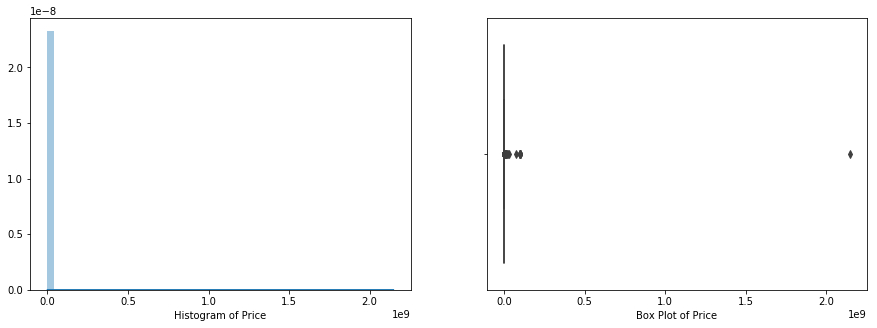

In [87]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax1,ax2 = axes.flatten()

g = sns.distplot(df4['price'],ax=ax1)
g.set_xlabel('Histogram of Price')

g2 = sns.boxplot(df4['price'],ax=ax2)
g2.set_xlabel('Box Plot of Price')

In [88]:
df4['price'].describe()

count    2.677890e+05
mean     1.929762e+04
std      4.203252e+06
min      0.000000e+00
25%      1.150000e+03
50%      2.950000e+03
75%      7.200000e+03
max      2.147484e+09
Name: price, dtype: float64

##### Inference
* There are rows with price 0. These row are suspicious since price cannot be zero. We will delete such rows.
* We can see that there is a large gap in the 75th percentile and the max price. We can see this in boxplot too. We will delete such extreme rows or outliers since they will impact our coefficients. 
* As visible in the box plot we can see that there is only 1 extreme value of 2.147484e+09 . We will delete this row

In [89]:
max_price = df4['price'].max()
df4 = df4.loc[~(df4['price'] ==max_price),:]
df4.shape

(267788, 11)

In [90]:
# A car cannot have a 0 price. Hence we will delete such rows.
df4[df4['price'] == 0].count()

price                  7821
abtest                 7821
vehicleType            7821
yearOfRegistration     7821
gearbox                7821
powerPS                7821
kilometer              7821
monthOfRegistration    7821
fuelType               7821
brand                  7821
notRepairedDamage      7821
dtype: int64

#### Deleting rows with 0 price

In [91]:
df4 = df4[df4['price'] != 0]
df4.shape

(259967, 11)

In [92]:
df4.loc[df4.price < 100].count()

price                  1822
abtest                 1822
vehicleType            1822
yearOfRegistration     1822
gearbox                1822
powerPS                1822
kilometer              1822
monthOfRegistration    1822
fuelType               1822
brand                  1822
notRepairedDamage      1822
dtype: int64

##### Outlier Removal in  Price column

In [93]:
Q1 = df4['price'].quantile(0.25)
Q3 = df4['price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

6249.0


In [94]:
((df4['price'] < (Q1 - 1.5 * IQR)) | (df4['price'] > (Q3 + 1.5 * IQR))).sum()

19094

In [95]:
df4.shape

(259967, 11)

In [96]:
df5 = df4.loc[~((df4['price'] < (Q1 - 1.5 * IQR)) | (df4['price'] > (Q3 + 1.5 * IQR))),:]
df5.shape

(240873, 11)

Text(0.5, 0, 'Box Plot of Price')

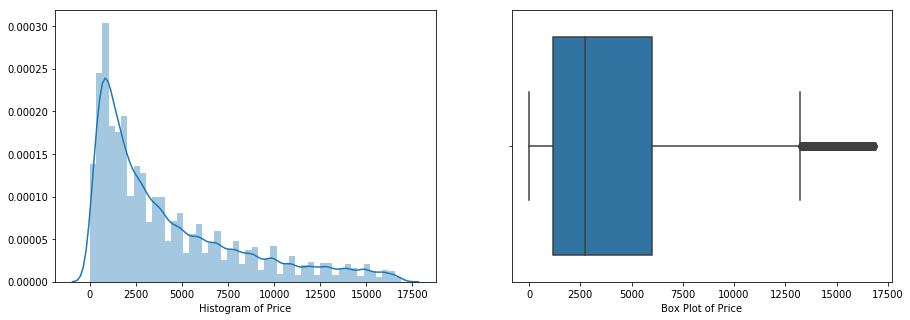

In [97]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax1,ax2 = axes.flatten()

g = sns.distplot(df5['price'],ax=ax1)
g.set_xlabel('Histogram of Price')

g2 = sns.boxplot(df5['price'],ax=ax2)
g2.set_xlabel('Box Plot of Price')

##### Inference
* We can see how removing outliers resulted in a better distribution of the Price

##### 2. yearOfRegistration

In [98]:
df5['yearOfRegistration'].value_counts()

2000.0    16638
1999.0    15642
2005.0    15465
2001.0    14091
2003.0    14004
2006.0    13980
2004.0    13778
2002.0    13389
1998.0    12312
2007.0    11874
2008.0    10465
1997.0    10093
2009.0     9725
1996.0     7508
2017.0     7017
2010.0     6972
1995.0     6530
2016.0     6440
2011.0     6120
2012.0     4214
1994.0     3365
2018.0     2687
2013.0     2305
1993.0     2297
1992.0     2008
1991.0     1901
1990.0     1799
2014.0     1331
1989.0      873
2015.0      682
          ...  
2290.0        1
3200.0        1
1111.0        1
9450.0        1
4800.0        1
1039.0        1
1001.0        1
2066.0        1
2200.0        1
2222.0        1
6500.0        1
5600.0        1
1255.0        1
2500.0        1
5911.0        1
1949.0        1
1944.0        1
1936.0        1
1930.0        1
1925.0        1
1923.0        1
1400.0        1
5555.0        1
3800.0        1
5900.0        1
3700.0        1
5300.0        1
1300.0        1
1600.0        1
4100.0        1
Name: yearOfRegistration

##### Inference
* We can see there are some strange values for year ie 2500 , 5555 , 6200 etc. We would remove these rows rather than imputing them with some random number
* Assuming someone would really sell the first motorized car ever build (1863), we will delete rows below 

In [99]:
df5 = df5[(df5['yearOfRegistration'] > 1863) & (df5['yearOfRegistration'] < 2020)]
df5['yearOfRegistration'].value_counts()

2000.0    16638
1999.0    15642
2005.0    15465
2001.0    14091
2003.0    14004
2006.0    13980
2004.0    13778
2002.0    13389
1998.0    12312
2007.0    11874
2008.0    10465
1997.0    10093
2009.0     9725
1996.0     7508
2017.0     7017
2010.0     6972
1995.0     6530
2016.0     6440
2011.0     6120
2012.0     4214
1994.0     3365
2018.0     2687
2013.0     2305
1993.0     2297
1992.0     2008
1991.0     1901
1990.0     1799
2014.0     1331
1989.0      873
2015.0      682
          ...  
1961.0       26
1959.0       19
1956.0       18
2019.0       13
1958.0       11
1957.0       10
1950.0        9
1953.0        8
1955.0        8
1951.0        7
1937.0        7
1954.0        6
1952.0        6
1929.0        6
1945.0        3
1934.0        3
1938.0        3
1935.0        2
1928.0        2
1932.0        2
1940.0        2
1941.0        2
1942.0        2
1943.0        2
1936.0        1
1930.0        1
1949.0        1
1925.0        1
1923.0        1
1944.0        1
Name: yearOfRegistration

In [100]:
df5.shape

(240773, 11)

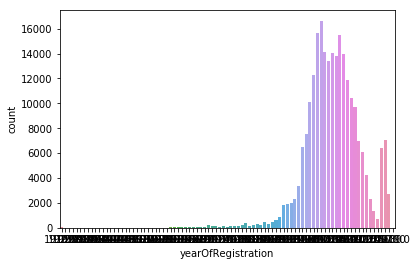

In [101]:
sns.countplot(df5['yearOfRegistration'])

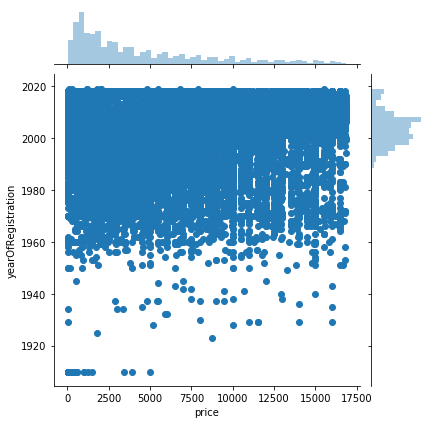

In [102]:
sns.jointplot(df5['price'],df5['yearOfRegistration'])

##### Inference
* Most of the cars belong to year of Registration between 1999-2009

##### 3. powerPS

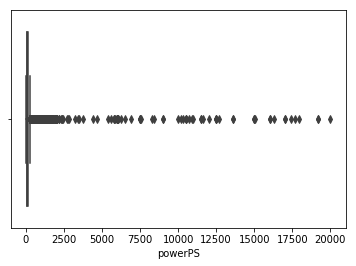

In [103]:
sns.boxplot(df5['powerPS'])

In [104]:
df5['powerPS'].describe()

count    240773.000000
mean        108.965582
std         192.737637
min           0.000000
25%          69.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: powerPS, dtype: float64

In [105]:
# Checking for number of rows which have 0 powerPS
df5[df5['powerPS'] == 0].count()

price                  25904
abtest                 25904
vehicleType            25904
yearOfRegistration     25904
gearbox                25904
powerPS                25904
kilometer              25904
monthOfRegistration    25904
fuelType               25904
brand                  25904
notRepairedDamage      25904
dtype: int64

In [106]:
df5.loc[df5['powerPS'] > 1000,'powerPS'].count()

193

##### Deleting rows containing powerPS less than 0

In [107]:
df5 = df5[(df5['powerPS'] >0)]
df5.shape

(214869, 11)

In [108]:
df5.loc[df5['powerPS'] > 1000,:] = 1000

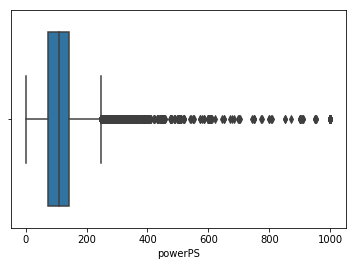

In [109]:
sns.boxplot(df5['powerPS'])

Text(0.5, 1.0, 'powerPS after capping Outliers')

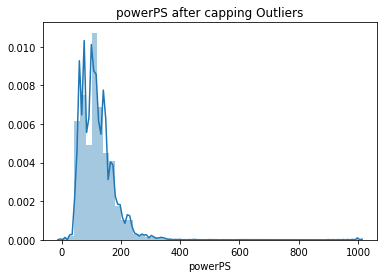

In [110]:
g = sns.distplot(df5['powerPS'])
g.set_title('powerPS after capping Outliers')

##### 4. monthOfRegistration

In [111]:
# Checking for number of rows which have 0 powerPS
df5[df5['monthOfRegistration'] == 0].count()

price                  14337
abtest                 14337
vehicleType            14337
yearOfRegistration     14337
gearbox                14337
powerPS                14337
kilometer              14337
monthOfRegistration    14337
fuelType               14337
brand                  14337
notRepairedDamage      14337
dtype: int64

##### We will delete this column as it has too many 0s and we are not sure how to impute this column

In [112]:
df5.drop('monthOfRegistration',axis=1,inplace=True)
df5.shape

(214869, 10)

In [113]:
df5.describe()

,price,yearOfRegistration,powerPS
count,214869.000000,214869.000000,214869.000000
mean,4408.126291,2002.236330,119.068735
std,4001.844771,30.823994,59.360125
min,1.000000,1000.000000,1.000000
25%,1299.000000,1999.000000,75.000000
50%,2999.000000,2003.000000,109.000000
75%,6500.000000,2007.000000,144.000000
max,16870.000000,2019.000000,1000.000000


##### Inference
* These values look quite okay now.

In [114]:
df5.dtypes

price                 float64
abtest                 object
vehicleType            object
yearOfRegistration    float64
gearbox                object
powerPS               float64
kilometer              object
fuelType               object
brand                  object
notRepairedDamage      object
dtype: object

In [115]:
#Changing kilometer to float
df5['kilometer'] = df5['kilometer'].astype('float')
df5.dtypes

price                 float64
abtest                 object
vehicleType            object
yearOfRegistration    float64
gearbox                object
powerPS               float64
kilometer             float64
fuelType               object
brand                  object
notRepairedDamage      object
dtype: object

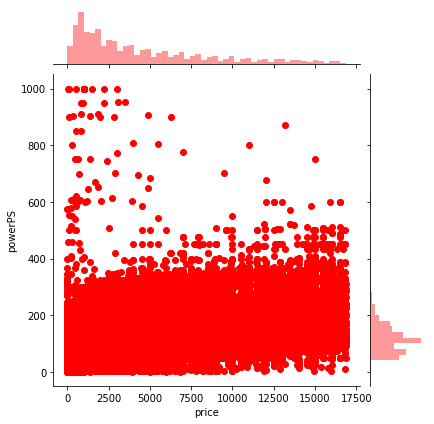

In [116]:
sns.jointplot(df5['price'],df5['powerPS'],color='red',kind='scatter')

##### Inference 
* We can see that even for powerPS > 600 the price is shown to be low which is strange. The highest price cars have powerPS below 600
* Lets cap powerPS of above 600 to 600

In [117]:
df5.loc[df5['powerPS'] > 600,'powerPS'] = 600
df5.loc[df5['powerPS'] > 600,'powerPS'].count()

0

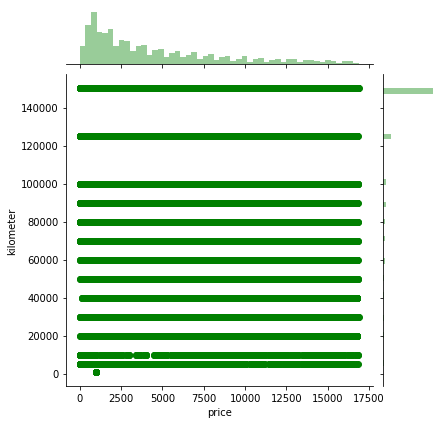

In [118]:
sns.jointplot(df5['price'],df5['kilometer'],color='green')

##### Inference 
* We can see not much can be concluded from this graph as price has less relation with kilometers here

In [119]:
df5.columns

Index(['price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

## Model Building

### Preparing Data

#### Checking correlation

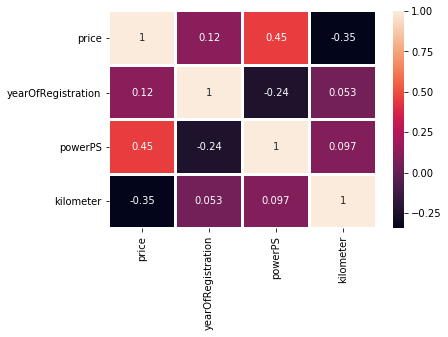

In [120]:
sns.heatmap(df5.corr(),annot=True,linecolor='white',linewidths=2)

#### Dummy Variable For categorical columns

In [121]:
X = df5.loc[:,~df5.columns.isin(['price'])]
y = df5['price']
X_dummy = pd.get_dummies(X,drop_first=True,prefix_sep='_')
print(X_dummy.columns)

Index(['yearOfRegistration', 'powerPS', 'kilometer', 'abtest_control',
       'abtest_test', 'vehicleType_Not-Known', 'vehicleType_andere',
       'vehicleType_bus', 'vehicleType_cabrio', 'vehicleType_coupe',
       'vehicleType_kleinwagen', 'vehicleType_kombi', 'vehicleType_limousine',
       'vehicleType_suv', 'gearbox_Not-Known', 'gearbox_automatik',
       'gearbox_manuell', 'fuelType_Not-Known', 'fuelType_andere',
       'fuelType_benzin', 'fuelType_cng', 'fuelType_diesel',
       'fuelType_elektro', 'fuelType_hybrid', 'fuelType_lpg',
       'brand_alfa_romeo', 'brand_audi', 'brand_bmw', 'brand_chevrolet',
       'brand_chrysler', 'brand_citroen', 'brand_dacia', 'brand_daewoo',
       'brand_daihatsu', 'brand_fiat', 'brand_ford', 'brand_honda',
       'brand_hyundai', 'brand_jaguar', 'brand_jeep', 'brand_kia',
       'brand_lada', 'brand_lancia', 'brand_land_rover', 'brand_mazda',
       'brand_mercedes_benz', 'brand_mini', 'brand_mitsubishi', 'brand_nissan',
       'brand_opel', 

#### checking multicollinearity among dummy variables too  
generally not required  

In [122]:
df_new = pd.get_dummies(df5,drop_first=True,prefix_sep='_')

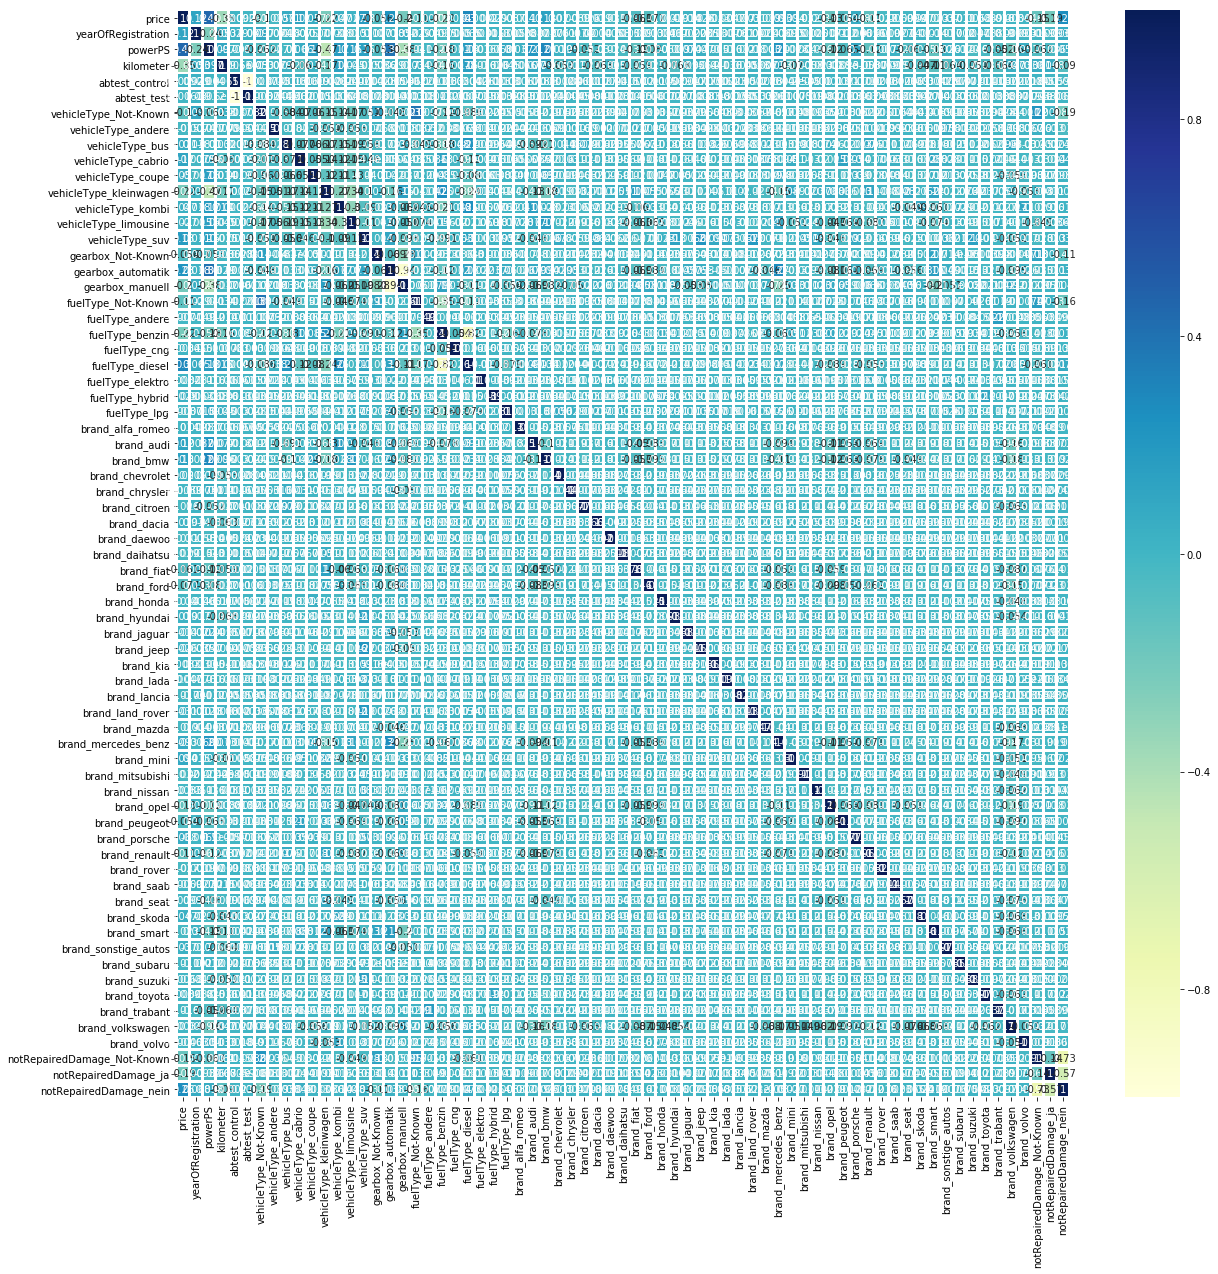

In [123]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_new.corr(),annot=True,linecolor='white',linewidths=2, ax=ax,cmap='YlGnBu')
plt.show()

#### splitting into train and test data

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.3, random_state=0)

#### Scaling Variables

In [125]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

c:\users\aviral agarwal\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\aviral agarwal\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\users\aviral agarwal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### 1.Fitting a Linear Regression Model  
one scaled data with default options

In [802]:
linear_model = LinearRegression()

linear_model.fit(X_train_scaled,y_train)

y_pred_train = linear_model.predict(X_train_scaled)
rmse_t = np.sqrt(mean_squared_error(y_train,y_pred_train))
r2_t = r2_score(y_train,y_pred_train)
print('Root mean squared error on Training Set', rmse_t)
print('R2 score on Train Set: ', r2_t)


y_pred_linear = linear_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_linear))
r2 = r2_score(y_test,y_pred_linear)
print('Root mean squared error on Testing Set', rmse)
print('R2 score on Testing Set: ', r2)

Root mean squared error on Training Set 2464.65670046831
R2 score on Train Set:  0.6190574197676098
Root mean squared error on Testing Set 2481.3298348429403
R2 score on Testing Set:  0.6193421983998604


Text(0.5, 1.0, 'Actual Vs Predicted')

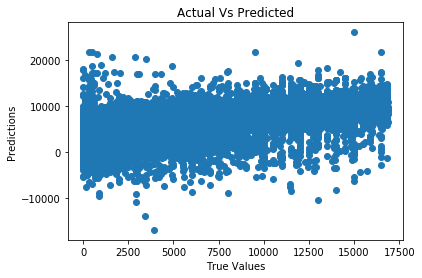

In [636]:
plt.scatter(y_test, y_pred_linear)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title('Actual Vs Predicted')

### 2. Non Linear Model - Using Polynomial Features

In [230]:
# creating polynomial features of degree 2 for NonLinear Regression
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_poly = poly_reg.fit_transform(X_dummy)


# creating Non Linear Regression Model
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

y_pred_poly = linear_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_poly))
r2 = r2_score(y_test,y_pred_poly)
print('Root mean squared error on Testing Set', rmse)
print('R2 score on Testing Set: ', r2)


MemoryError: 

### 3. Ridge Model

In [791]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(random_state=0) #Keeping any alpha and tol is not improving the performance so removed it
ridge_reg.fit(X_train_scaled,y_train)
y_pred_ridge = linear_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test,y_pred_ridge))
r2 = r2_score(y_test,y_pred_ridge)

print('Root mean squared error on Testing Set', rmse)
print('R2 score on Testing Set: ', r2)

Root mean squared error on Testing Set 2481.3298348429403
R2 score on Testing Set:  0.6193421983998604


### 4. Lasso Model

In [792]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=1.0,random_state=0)
lasso_reg.fit(X_train_scaled,y_train)
y_pred_lasso = linear_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test,y_pred_lasso))
r2 = r2_score(y_test,y_pred_lasso)

print('Root mean squared error on Testing Set', rmse)
print('R2 score on Testing Set: ', r2)

Root mean squared error on Testing Set 2481.3298348429403
R2 score on Testing Set:  0.6193421983998604


C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### 5. OLS Model

In [793]:
import statsmodels.api as sm
import statsmodels.formula.api as sm 
from statsmodels.formula.api import ols
from IPython.display import HTML, display

X1= X_dummy.copy()
X['intercept'] = np.ones((X.shape[0],),dtype=int) #Adding an intercept column of value 1 - constant (Beta -0)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.3, random_state=0)

ols_model = sm.OLS(y_train1,X_train1).fit()
ols_model_summary = ols_model.summary()
HTML(ols_model_summary.as_html())

### 6. XGBoost

Best Parameters for XGBoost found empirically  

GENERAL PARAMETERS  
1. *booster* = gbtree(default), type of base learners  
2. *silent* = 0(default), whether we want messages from xgboost, 0 for yes  
3. *nthread* =  do nothing, will automatically pick all cores available  

BOOSTER PARAMETERS for tree boosters as that is the best  
1. *eta* = **default 0.3, empirically between 0.01 and 0.2**, like learning rate in GBM  
2. *min_child_weight* = **default 1** sum of weights in each child node or leaf. very high leads to underfitting. **to be found using CrossValidation**    
3. *max_depth* = depth of tree learners, **default 6, emirically between 3 to 10**  
4. *max_leaf_nodes* = set by max_depth as it is equal to 2^max_depth  
5. *gamma* = default 0, minimum loss reduction required to make a split  
6. *subsample* = fraction of observation to be take for each learner tree. **default 1, empirically between 0.5 and 1**.  
7. *colsample_bytree* = fraction of columns in sample of training data from learner trees, **default=1, empirically 
between 0.5 and 1**  
8. *lambda* = L2 or Ridge Regularization, **default 1**   
9. *alpha* = L1 or Lasso Regularization, to be used when there are a lot of dimensions or features , **default 0**  
10. *scale_pos_weight* = **default=1**, A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence  

 
LEARNING TASK PARAMETERS used to define the optimization objective  
1. *objective* = default=reg:linear, This defines the loss function to be minimized. Mostly used values are  
   **binary:logistic** –logistic regression for binary classification, returns predicted probability (not class)  
   **multi:softmax** –multiclass classification using the softmax objective, returns predicted class (not probabilities), you also need to set an additional num_class (number of classes) parameter defining the number of unique classes  
   **multi:softprob** –same as softmax, but returns predicted probability of each data point belonging to each class.  
   
2. *eval_metric* = metric to be used for validation data. default values are **rmse for regression** and **error for classification**.  
3. *num_boosting_rounds* = no. of trees or boosting rounds, **find using CrossValidation**  




**General Approach for Parameter Tuning**  

We will use an approach similar to that of GBM here. The various steps to be performed are:  

1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems.
    a. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.  
2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.  
3. Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.  
4. Lower the learning rate and decide the optimal parameters .  


**Data Preparation for xgboost**
1. no categorical variable  
2. no need to handle missing values are xgboost is capable of handling them  

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [134]:
# separating independent features and dependent or target feature
X = df5.loc[:,~df5.columns.isin(['price'])]
y = df5['price']

# encoding using ONE HOT ENCODER
X_dummy = pd.get_dummies(X,drop_first=True,prefix_sep='_')


# convert the dataset into an optimized data structure 
# called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains.
data_dmatrix = xgb.DMatrix(data=X_dummy,label=y)


# creating train and test data
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.2, random_state=123)

#### Basic XGBRegressor with any empirical parameter values

In [135]:
# XGBRegressor for Regression
xg_reg_basic = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [147]:
#Fit the regressor to the training set and make predictions on the test set using 
#the familiar .fit() and .predict() methods.
xg_reg_basic.fit(X_train,y_train,eval_metric="rmse")

preds = xg_reg_basic.predict(X_test)

c:\users\aviral agarwal\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [148]:
# calculation RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print('R-squared: ', r2_score(y_test,preds))

RMSE: 3338.227251
R-squared:  0.30293990863577036


##### k-fold Cross Validation using XGBoost  using xgb.cv() method  to find n_estimators
what does xgb.cv() do?  
it does boosting rounds specified by num_boost_round but limited by early_stopping_rounds. It then gives results(according to specified metrics) for each boosting round (1 round = 1 tree in boosting) and outputs them in a dataframe.

following are the options in xgb.cv()  

1. num_boost_round: denotes the number of trees you build (analogous to n_estimators)  
2. metrics: tells the evaluation metrics to be watched during CV  
3. as_pandas: to return the results in a pandas DataFrame.  
4. early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.  
5. seed: for reproducibility of results.  


dtain = all the data we have as we are using cross validation  
params = all the parameters for XGBRegressor object  
n_fold = k in k-folds cross validation  

In [186]:
# set 1 of basic parameters set empirically
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [187]:
# set 2 of basic parameters set empirically
#param_grid = {
#    'learning_rate': 0.3,
#    'max_depth': 5,
#    'min_child_weight': 6,
#    'subsample': 0.8,
#    'colsample_bytree': 0.8,
#    'objective': 'reg:linear',
#    'seed': 27
#}

print("Start of xgv.cv  {0}".format(datetime.datetime.now()))
cv_results2 = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=2000,early_stopping_rounds=50,metrics="rmse", seed=123)
print("End of xgv.cv  {0}".format(datetime.datetime.now()))

In [190]:
cv_results2.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
1995,1376.791992,1.882469,1513.024699,4.165592
1996,1376.744181,1.868714,1513.026937,4.177441
1997,1376.694011,1.898051,1513.041585,4.175463
1998,1376.629028,1.863386,1513.049072,4.171274
1999,1376.588379,1.856409,1513.042236,4.181650


**plotting train-rmse-mean and test-rmse-mean from cv_results to see when we are starting to overfit**

In [193]:
temp=cv_results2.copy()
temp=temp.reset_index()
temp=temp.rename(columns={'index':'num_boosting_round or n_estimators'})

In [194]:
temp.head()

,num_boosting_round or n_estimators,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0,5600.005208,2.408840,5600.007813,6.291290
1,1,5286.935384,9.020497,5287.146973,5.154359
2,2,4886.892090,7.112853,4887.162435,2.497358
3,3,4574.625000,58.183089,4575.640951,49.121161
4,4,4349.418945,69.581931,4350.731771,58.778638


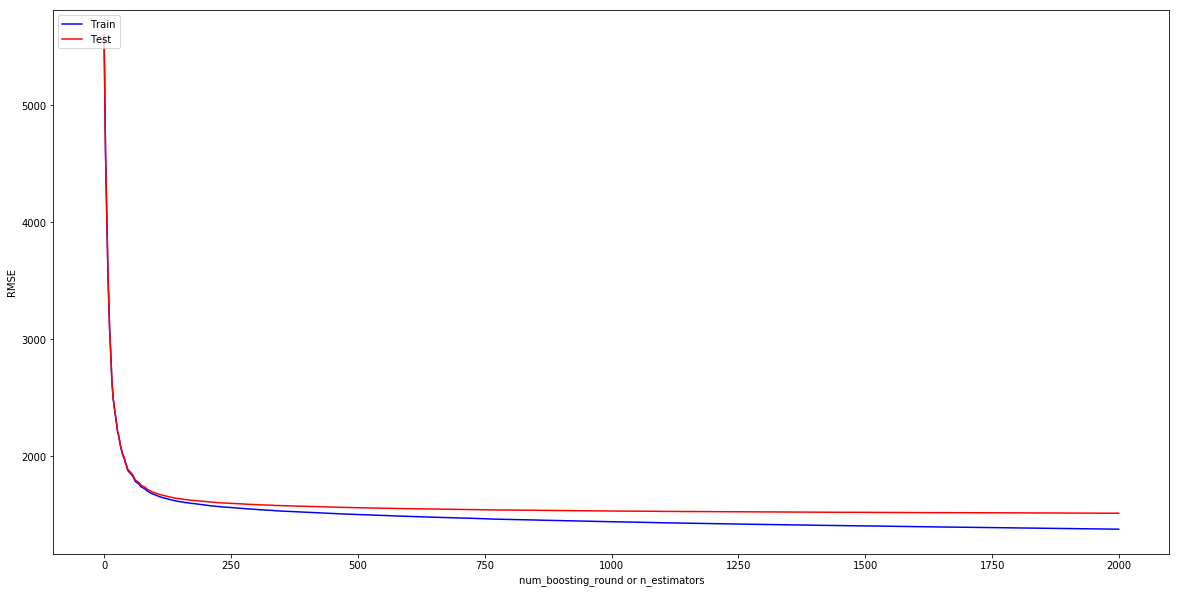

In [198]:
plt.figure(figsize=(20,10))
plt.plot(temp['num_boosting_round or n_estimators'], temp['train-rmse-mean'], 'b', label='Train RMSE')
plt.plot(temp['num_boosting_round or n_estimators'], temp['test-rmse-mean'], 'r', label='Test RMSE')
plt.legend(["Train","Test"],loc=2)
plt.ylabel('RMSE')
plt.xlabel('num_boosting_round or n_estimators')
plt.show()

**Observation**: as we can see, after **n_estimators = around 125**, the decrease in RMSE is not much.  
Also, there is no overfitting as RMSE on train and test data set is decreasing  

*why GridSearchCV is not effective method for finding n_estimators?*   
because RMSE is still decreasing but very slowly. SO GridSearchCV will give n_estimators for lowest RMSE which might not be very efficient. For n_estimator range(0:2000), GridSearchCV will give 2000 as the best n_estimator.

#### XGBRegressor with tuned n_estimators

In [209]:
param_tuned = {
    'learning_rate': 0.3,
    'max_depth': 5,
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'seed': 27,
    'n_estimators': 125
}
xg_reg_tuned = xgb.XGBRegressor(params=param_tuned)

In [211]:
# fitting on train data
xg_reg_tuned.fit(X_train,y_train,eval_metric="rmse")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear',
       params={'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'reg:linear', 'seed': 27, 'n_estimators': 125},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [213]:
# predicting on test data
preds_tuned = xg_reg_tuned.predict(X_test)

In [228]:
print('On TEST DATA')
# calculation RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds_tuned))
print("RMSE: %f" % (rmse))

r_square=r2_score(y_test,preds_tuned)
print('R-squared: ', r_square)

# adjusted_r_square
adjusted_r_square = 1-(((1-r_square)*(len(y_test)-1))/(len(y_test)-X_test.shape[1]-1))
print('Adjusted R-squared: ', adjusted_r_square)

On TEST DATA
RMSE: 1776.364799
R-squared:  0.8026201840132103
Adjusted R-squared:  0.8023073573616055


**Observation**: even after taking empirically chosen parameters and tuning only one parameter(n_estimators), xgboost gave a much better result.  

We can furthur tune the parameters using this value of n_estimators and using GridSearchCV to tune tree parameters. Eventually we can try to reduce learning rate too.

In [225]:
# plotting feature importance according the xgboost model
xgb.plot_importance(xg_reg_tuned)
plt.rcParams['figure.figsize'] = [200, 205]
plt.show()